In [3]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing, pipeline
import torch
from torch import nn, optim, utils

In [13]:
def clip_gradients_(
    clip_grad_strategy,
    model_fn,
    clip_value=None,
    error_if_nonfinite=False,
    max_norm=None,
    norm_type=2.0):
    if clip_grad_strategy == "value" and clip_value is not None:
        nn.utils.clip_grad_value_(
            model_fn.parameters(),
            clip_value
        )
    elif clip_grad_strategy == "norm" and max_norm is not None:
        nn.utils.clip_grad_norm_(
            model_fn.parameters(),
            max_norm,
            norm_type,
            error_if_nonfinite
        )
    elif clip_grad_strategy is None:
        pass
    else:
        raise NotImplementedError()


def compute_average_loss(dataloader, loss_fn, model_fn):
    total_loss = torch.zeros(1, 1)
    for features, targets in dataloader:
        predictions = model_fn(features)        
        total_loss += loss_fn(predictions, targets)
    average_loss = total_loss / len(dataloader)
    return average_loss


def initialize_linear_layer(
    in_features,
    out_features,
    init_strategy_=nn.init.kaiming_uniform_):
    linear_layer = nn.Linear(in_features, out_features)
    init_strategy_(linear_layer.weight)
    return linear_layer


def make_mlp_classifier(
    input_size,
    hidden_sizes=None,
    output_size=2,
    activation_fn=None,
    init_strategy_=nn.init.kaiming_uniform_,
    batch_normalization=False):
    modules = []
    hidden_sizes = [] if hidden_sizes is None else hidden_sizes
    for hidden_size in hidden_sizes:
        hidden_layer = initialize_linear_layer(
            input_size,
            hidden_size,
            init_strategy_,
        )
        modules.append(hidden_layer)
        if batch_normalization:
            modules.append(nn.BatchNorm1d(hidden_size))
        if activation_fn is not None:
            modules.append(activation_fn)
        input_size=hidden_size
    output_layer = initialize_linear_layer(
            input_size,
            output_size,
            init_strategy_,
    )
    modules.append(output_layer)
    modules.append(nn.LogSoftmax(dim=1))
    model_fn = nn.Sequential(*modules)
    return model_fn, nn.NLLLoss()


In [14]:
def fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    clip_grad_strategy=None,
    clip_value=None,
    error_if_nonfinite=False,
    lr_scheduler=None,
    log_epochs=1,
    max_epochs=1,
    max_norm=None,
    norm_type=2.0):
  
    history = {
        "epoch": [],
        "average_train_loss": [],
        "average_val_loss": []
    }

    for epoch in range(max_epochs):
        total_train_loss = torch.zeros(1, 1)
        model_fn = model_fn.train()
        for features, targets in train_dataloader:
            
            # forward pass
            predictions = model_fn(features)        
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

            # backward pass
            loss.backward()
            clip_gradients_(
                clip_grad_strategy,
                model_fn,
                clip_value,
                error_if_nonfinite,
                max_norm,
                norm_type
            )
            optimizer.step()        
            optimizer.zero_grad()
        
        average_train_loss = total_train_loss / len(train_dataloader)
        history["epoch"].append(epoch)
        history["average_train_loss"].append(average_train_loss.item())

        # validation after every training epoch
        model_fn = model_fn.eval()
        with torch.inference_mode():
            average_val_loss = compute_average_loss(
                val_dataloader,
                loss_fn,
                model_fn
            )
        history["average_val_loss"].append(average_val_loss.item())

        # update the learning rate after every training epoch
        if lr_scheduler is not None:
            lr_scheduler.step()

        if epoch % log_epochs == 0:
            message = f"Epoch {epoch}, Average train Loss {average_train_loss.item():.4f}, Average val Loss {average_val_loss.item():.4f}"
            print(message)

    history_df = (pd.DataFrame.from_dict(history)
                              .set_index("epoch"))
    return history_df


## Load the data

In [15]:
INPUT_SIZE = 784
OUTPUT_SIZE = 10

_train_data = pd.read_csv(
    "./sample_data/mnist_train_small.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)
train_data, val_data = model_selection.train_test_split(
    _train_data,
    test_size=0.1,
    stratify=_train_data.loc[:, "label"]
)

test_data = pd.read_csv(
    "./sample_data/mnist_test.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)


In [16]:
features_preprocessor = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    preprocessing.FunctionTransformer(lambda arr: arr.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)

target_preprocessor = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda df: df.to_numpy()),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)


In [17]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# create the training dataset and dataloader
train_features_tensor = features_preprocessor.fit_transform(
    train_data.drop("label", axis=1)
)

train_target_tensor = target_preprocessor.fit_transform(
    train_data.loc[:, "label"]
)

train_dataset = utils.data.TensorDataset(
    train_features_tensor,
    train_target_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the validation dataset and dataloader
val_features_tensor = features_preprocessor.transform(
    val_data.drop("label", axis=1)
)

val_target_tensor = target_preprocessor.transform(
    val_data.loc[:, "label"]
)

val_dataset = utils.data.TensorDataset(
    val_features_tensor,
    val_target_tensor
)

val_dataloader = utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the test dataset and dataloader
test_features_tensor = features_preprocessor.transform(
    test_data.drop("label", axis=1)
)

test_target_tensor = target_preprocessor.transform(
    test_data.loc[:, "label"]
)

test_dataset = utils.data.TensorDataset(
    test_features_tensor,
    test_target_tensor
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)


# Regularization

## L2 Regularization via Weight Decay

### SGD

Epoch 0, Average train Loss 0.4702, Average val Loss 0.6523
Epoch 1, Average train Loss 0.3180, Average val Loss 0.5056
Epoch 2, Average train Loss 0.2933, Average val Loss 0.4395
Epoch 3, Average train Loss 0.2791, Average val Loss 0.3925
Epoch 4, Average train Loss 0.2684, Average val Loss 0.3689
Epoch 5, Average train Loss 0.2597, Average val Loss 0.3553
Epoch 6, Average train Loss 0.2523, Average val Loss 0.3327
Epoch 7, Average train Loss 0.2457, Average val Loss 0.3142
Epoch 8, Average train Loss 0.2397, Average val Loss 0.2992
Epoch 9, Average train Loss 0.2343, Average val Loss 0.2855
Epoch 10, Average train Loss 0.2295, Average val Loss 0.2778
Epoch 11, Average train Loss 0.2251, Average val Loss 0.2691
Epoch 12, Average train Loss 0.2213, Average val Loss 0.2627
Epoch 13, Average train Loss 0.2178, Average val Loss 0.2565
Epoch 14, Average train Loss 0.2148, Average val Loss 0.2518
Epoch 15, Average train Loss 0.2120, Average val Loss 0.2482
Epoch 16, Average train Loss 0.209

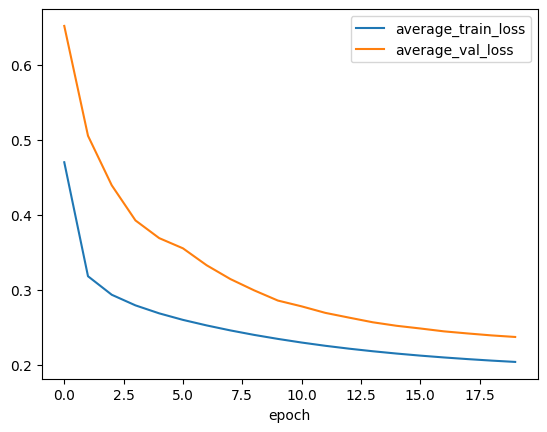

In [21]:
HIDDEN_SIZE = 100
LEARNING_RATE = 1e-1
WEIGHT_DECAY = 1e-2
MAX_EPOCHS = 20

model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_,
)

optimizer = optim.SGD(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

### AdamW

In [23]:
optim.AdamW?

Epoch 0, Average train Loss 7.5067, Average val Loss 1.1653
Epoch 1, Average train Loss 0.7703, Average val Loss 0.7386
Epoch 2, Average train Loss 0.4546, Average val Loss 0.5158
Epoch 3, Average train Loss 0.4203, Average val Loss 0.5653
Epoch 4, Average train Loss 0.4979, Average val Loss 1.3490
Epoch 5, Average train Loss 0.6195, Average val Loss 0.8220
Epoch 6, Average train Loss 0.4152, Average val Loss 0.5968
Epoch 7, Average train Loss 0.4918, Average val Loss 10.9690
Epoch 8, Average train Loss 0.3571, Average val Loss 10.9019
Epoch 9, Average train Loss 0.2876, Average val Loss 7.2811
Epoch 10, Average train Loss 0.3061, Average val Loss 5.9665
Epoch 11, Average train Loss 0.2691, Average val Loss 1.8835
Epoch 12, Average train Loss 0.2825, Average val Loss 3.6636
Epoch 13, Average train Loss 0.2523, Average val Loss 3.4825
Epoch 14, Average train Loss 0.2493, Average val Loss 1.5854
Epoch 15, Average train Loss 0.2329, Average val Loss 1.3501
Epoch 16, Average train Loss 0.1

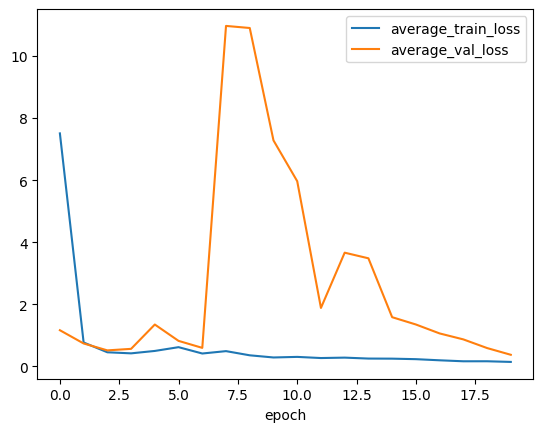

In [22]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_,
)

optimizer = optim.AdamW(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Regularization via explicit penalty

In [25]:
def fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    clip_grad_strategy=None,
    clip_value=None,
    error_if_nonfinite=False,
    lr_scheduler=None,
    log_epochs=1,
    max_epochs=1,
    max_norm=None,
    norm_type=2.0,
    penalty_fn=None,
    eta=1e-2):
  
    history = {
        "epoch": [],
        "average_train_loss": [],
        "average_val_loss": []
    }

    for epoch in range(max_epochs):
        total_train_loss = torch.zeros(1, 1)
        model_fn = model_fn.train()
        for features, targets in train_dataloader:
            
            # forward pass
            predictions = model_fn(features)        
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

            # add a penalty term
            if penalty_fn is not None:
                cost = loss + eta * penalty_fn(model_fn.parameters())
            else:
                cost = loss

            # backward pass
            cost.backward()
            clip_gradients_(
                clip_grad_strategy,
                model_fn,
                clip_value,
                error_if_nonfinite,
                max_norm,
                norm_type
            )
            optimizer.step()        
            optimizer.zero_grad()
        
        average_train_loss = total_train_loss / len(train_dataloader)
        history["epoch"].append(epoch)
        history["average_train_loss"].append(average_train_loss.item())

        # validation after every training epoch
        model_fn = model_fn.eval()
        with torch.inference_mode():
            average_val_loss = compute_average_loss(
                val_dataloader,
                loss_fn,
                model_fn
            )
        history["average_val_loss"].append(average_val_loss.item())

        # update the learning rate after every training epoch
        if lr_scheduler is not None:
            lr_scheduler.step()

        if epoch % log_epochs == 0:
            message = f"Epoch {epoch}, Average train Loss {average_train_loss.item():.4f}, Average val Loss {average_val_loss.item():.4f}"
            print(message)

    history_df = (pd.DataFrame.from_dict(history)
                              .set_index("epoch"))
    return history_df


In [39]:
def elastic_net_penalty_fn(parameters, alpha):
    params_tensor = nn.utils.parameters_to_vector(parameters)
    l1_regularization = torch.norm(params_tensor, 1)
    l2_regularization = torch.norm(params_tensor, 2)
    penalty = alpha * l1_regularization + (1 - alpha) * l2_regularization
    return penalty


Epoch 0, Average train Loss 0.4754, Average val Loss 0.8515
Epoch 1, Average train Loss 0.3569, Average val Loss 0.9421
Epoch 2, Average train Loss 0.3604, Average val Loss 0.9524
Epoch 3, Average train Loss 0.3579, Average val Loss 0.8305
Epoch 4, Average train Loss 0.3499, Average val Loss 0.7447
Epoch 5, Average train Loss 0.3406, Average val Loss 0.6453
Epoch 6, Average train Loss 0.3312, Average val Loss 0.5790
Epoch 7, Average train Loss 0.3225, Average val Loss 0.5549
Epoch 8, Average train Loss 0.3149, Average val Loss 0.4913
Epoch 9, Average train Loss 0.3080, Average val Loss 0.4389
Epoch 10, Average train Loss 0.3020, Average val Loss 0.4147
Epoch 11, Average train Loss 0.2966, Average val Loss 0.3908
Epoch 12, Average train Loss 0.2921, Average val Loss 0.3780
Epoch 13, Average train Loss 0.2880, Average val Loss 0.3625
Epoch 14, Average train Loss 0.2843, Average val Loss 0.3503
Epoch 15, Average train Loss 0.2811, Average val Loss 0.3403
Epoch 16, Average train Loss 0.278

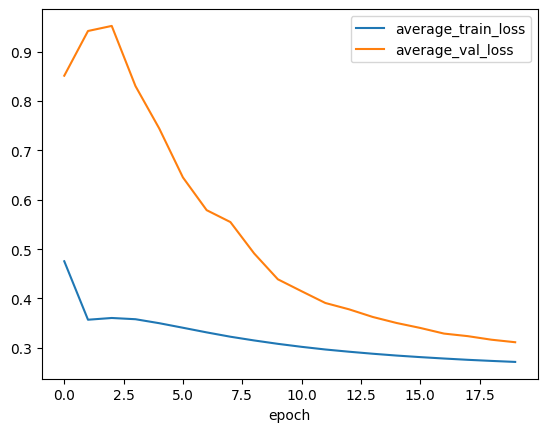

In [40]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_,
)

optimizer = optim.SGD(
    model_fn.parameters(),
    lr=LEARNING_RATE,
)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS,
    penalty_fn=lambda params: elastic_net_penalty_fn(params, alpha=0.1),
    eta=1e-2
)

_ = history.plot()

## Dropout

### Dropout on the input layer

In [9]:
def make_mlp_classifier(
    input_size,
    hidden_sizes=None,
    output_size=2,
    activation_fn=None,
    init_strategy_=nn.init.kaiming_uniform_,
    batch_normalization=False,
    input_layer_dropout=False,
    dropout_prob=None):
    modules = []
    if input_layer_dropout and dropout_prob is not None:
        modules.append(nn.Dropout(dropout_prob))
    hidden_sizes = [] if hidden_sizes is None else hidden_sizes
    for hidden_size in hidden_sizes:
        hidden_layer = initialize_linear_layer(
            input_size,
            hidden_size,
            init_strategy_,
        )
        modules.append(hidden_layer)
        if batch_normalization:
            modules.append(nn.BatchNorm1d(hidden_size))
        if activation_fn is not None:
            modules.append(activation_fn)
        input_size=hidden_size
    output_layer = initialize_linear_layer(
            input_size,
            output_size,
            init_strategy_,
    )
    modules.append(output_layer)
    modules.append(nn.LogSoftmax(dim=1))
    model_fn = nn.Sequential(*modules)
    return model_fn, nn.NLLLoss()


Epoch 0, Average train Loss 0.6711, Average val Loss 0.4234
Epoch 1, Average train Loss 0.4345, Average val Loss 0.3408
Epoch 2, Average train Loss 0.3514, Average val Loss 0.2867
Epoch 3, Average train Loss 0.2967, Average val Loss 0.2033
Epoch 4, Average train Loss 0.2743, Average val Loss 0.1919
Epoch 5, Average train Loss 0.2475, Average val Loss 0.1952
Epoch 6, Average train Loss 0.2363, Average val Loss 0.1797
Epoch 7, Average train Loss 0.2228, Average val Loss 0.1701
Epoch 8, Average train Loss 0.2084, Average val Loss 0.1591
Epoch 9, Average train Loss 0.2019, Average val Loss 0.1579
Epoch 10, Average train Loss 0.1895, Average val Loss 0.1560
Epoch 11, Average train Loss 0.1849, Average val Loss 0.1447
Epoch 12, Average train Loss 0.1822, Average val Loss 0.1481
Epoch 13, Average train Loss 0.1807, Average val Loss 0.1443
Epoch 14, Average train Loss 0.1711, Average val Loss 0.1433
Epoch 15, Average train Loss 0.1638, Average val Loss 0.1446
Epoch 16, Average train Loss 0.162

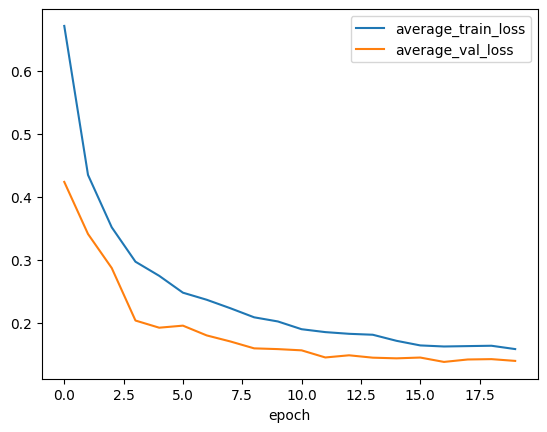

In [10]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_,
    input_layer_dropout=True,
    dropout_prob=0.5
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

### Dropout on hidden layers

In [41]:
def make_mlp_classifier(
    input_size,
    hidden_sizes=None,
    output_size=2,
    activation_fn=None,
    init_strategy_=nn.init.kaiming_uniform_,
    batch_normalization=False,
    input_layer_dropout=False,
    hidden_layer_dropout=False,
    dropout_prob=None):
    modules = []
    if input_layer_dropout and dropout_prob is not None:
        modules.append(nn.Dropout(dropout_prob))
    hidden_sizes = [] if hidden_sizes is None else hidden_sizes
    for hidden_size in hidden_sizes:
        hidden_layer = initialize_linear_layer(
            input_size,
            hidden_size,
            init_strategy_,
        )
        modules.append(hidden_layer)
        if batch_normalization:
            modules.append(nn.BatchNorm1d(hidden_size))
        if activation_fn is not None:
            modules.append(activation_fn)
        if hidden_layer_dropout and dropout_prob is not None:
            modules.append(nn.Dropout(dropout_prob))
        input_size=hidden_size
    output_layer = initialize_linear_layer(
            input_size,
            output_size,
            init_strategy_,
    )
    modules.append(output_layer)
    modules.append(nn.LogSoftmax(dim=1))
    model_fn = nn.Sequential(*modules)
    return model_fn, nn.NLLLoss()


Epoch 0, Average train Loss 1.0277, Average val Loss 0.5058
Epoch 1, Average train Loss 0.6571, Average val Loss 0.5487
Epoch 2, Average train Loss 0.5812, Average val Loss 0.4929
Epoch 3, Average train Loss 0.5264, Average val Loss 0.3390
Epoch 4, Average train Loss 0.5083, Average val Loss 0.4504
Epoch 5, Average train Loss 0.4793, Average val Loss 0.3571
Epoch 6, Average train Loss 0.4612, Average val Loss 0.3090
Epoch 7, Average train Loss 0.4443, Average val Loss 0.2893
Epoch 8, Average train Loss 0.4188, Average val Loss 0.2750
Epoch 9, Average train Loss 0.4187, Average val Loss 0.2926
Epoch 10, Average train Loss 0.4002, Average val Loss 0.2672
Epoch 11, Average train Loss 0.4002, Average val Loss 0.2663
Epoch 12, Average train Loss 0.3861, Average val Loss 0.2663
Epoch 13, Average train Loss 0.3796, Average val Loss 0.2569
Epoch 14, Average train Loss 0.3722, Average val Loss 0.2545
Epoch 15, Average train Loss 0.3711, Average val Loss 0.2522
Epoch 16, Average train Loss 0.365

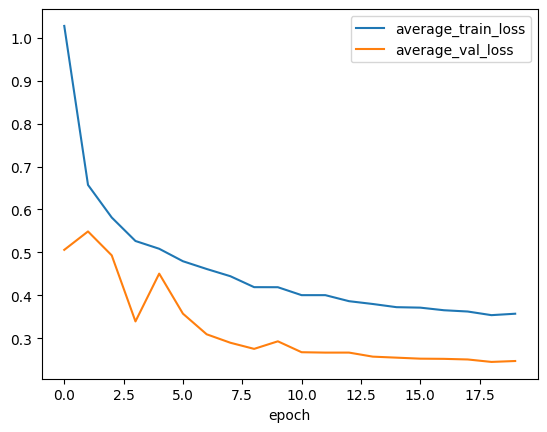

In [42]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_,
    hidden_layer_dropout=True,
    dropout_prob=0.5
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Monte Carlo Dropout

In [43]:
def enable_dropout(module):
    if type(module) == nn.Dropout:
        module.train()
    else:
        pass

In [49]:
PREDICTION_SIZE = 10

model_fn = model_fn.eval()
average_test_losses = torch.zeros(PREDICTION_SIZE)

with torch.inference_mode():
    model_fn.apply(enable_dropout)
    for i in range(PREDICTION_SIZE):
        average_test_loss = compute_average_loss(
            test_dataloader,
            loss_fn,
            model_fn
        )
        average_test_losses[i] = average_test_loss.item()

In [52]:
average_test_losses.mean()

tensor(0.3877)

In [53]:
average_test_losses.std()

tensor(0.0064)